In [1]:
pwd

In [2]:
import Py_FTP_Langevin as ftp
from ftp_support import *

Number of processors:  8


In [3]:
fontsize_axis = 20
fontsize_legend = 16
fontsize_ticks = 14

# First time passage simulations

In [4]:
export_ovito = False

In [5]:
file_export = "Sphere_without_vdW_regimes_save_all_v01"

In [6]:
#//! *********** PARAMETERS PARTICLE PROPERTIES *********** !
MM,Rho_p,epsilon_lj,sigma_lj,_ = Get_params_particles("Soot")
sigma_lj=0

#//! *********** SIMULATION PARAMETERS *********** !
N_runs = 5000 #; 500
Box_L_factor_dmax = 80 #80 #; //! Box size as factor of D_p
T_g = 1700. #;  1700          //! Fluid temperature
P_g = 101300. #;          //! Fluid pressure
phi_p = 0.01 / 100 #;   //! Particles number concentration (1000 ppm = 0.01)    
with_sticking = True
with_rel_motion = True
with_rotation = False
with_brownian = True
#factor_vdw , determined for each case

vdw_cutoff = 10

#//! *********** LANGEVIN PARAMETERS *********** !
run_taus_min = 120 #; // Keep in 100 to be accurate with LD theory (otherwise the 6*D*t is not strictly respected)
LD_dt_factor = 1e-01 #;

#//! *********** PARAMETERS INT. POTENTIALS *********** !
alpha_dp = 0.01 #0.01
alpha_dp_max = 0.1
direct = "aggregate_info";
#direct = "../../01_vdW_interactions/All_aggregates/FracVAL_DLCA";

In [7]:
files = ftp.get_dir_files(direct)
files.sort()
N_files = len(files)

In [8]:
#path_agg = direct + "/" + files[1000].decode('utf-8')
path_agg = direct + "/" + files[0].decode('utf-8')
print(path_agg)

aggregate_info/Agglomerate_N_000000001_Agg_00000001.dat


In [9]:
model = ftp.Pymodel(direct)
model

In [10]:
Dp_all = np.logspace(np.log10(1),np.log10(1e+03),10) * (1e-09)
#Dp_all = np.logspace(np.log10(0.01),np.log10(1e+03),10) * (1e-09)
Dp = np.max(Dp_all)
#Dp = np.min(Dp_all)

k_BT = k_B * T_g
#A = np.logspace(np.log10(0.5),np.log10(250),10) * k_BT
A = np.logspace(np.log10(0.5),np.log10(250),3) * k_BT
A = np.append(np.array([0]),A)

In [11]:
# Potential well analysis
e_well_i = np.zeros_like(Dp_all)
r_e_well_i = np.zeros_like(Dp_all)
factor_vdw_i = np.zeros_like(Dp_all)

for i in range(len(A)):
    #Dp = Dp_all[i]
    Ai = A[i]
    e_well,r_e_well = Determine_pot_well(Dp,Dp,Ai,sigma_lj,k_BT)
    e_well_i[i] = e_well
    r_e_well_i[i] = r_e_well
    factor_vdw_i[i] = r_e_well/(0.5*(Dp+Dp))

In [12]:
ftp.Init_Random()
#ftp.Make_output_folder()

In [13]:
def isNaN(num):
    if float('-inf') < float(num) < float('inf'):
        return False 
    else:
        return True

In [14]:
factor_vdw = 1
properties = \
    {"new_MM": MM,
     "new_Rhop": Rho_p,
     "new_N_runs": N_runs,
     "new_box_factor": Box_L_factor_dmax,
     "new_T": T_g,
     "new_P": P_g,
     "new_phi": phi_p,
     "new_runs_taus": run_taus_min,
     "new_LD_fact": LD_dt_factor,
     "new_A": A[0],
     "new_S_LJ": sigma_lj,
     "new_alpha_dp": alpha_dp,
     "new_alpha_dp_max": alpha_dp_max,
     "new_factor_vdw": factor_vdw,
     "new_D_pp": Dp,
     "new_vdw_cutoff": vdw_cutoff,
     "with_sticking": with_sticking,
     "with_rel_motion": with_rel_motion,
     "with_rotation": with_rotation,
     "with_brownian": with_brownian,
     "new_path": direct}
    
model = Set_model_properties(model,properties)

ftp_model = ftp.PyFTP(model)

In [15]:
ftp_model.Load_aggregates_external(path_agg, model)

In [16]:
ftp_times_j = np.zeros(len(Dp_all))
ftp_times_std_j = np.zeros(len(Dp_all))
Kn_d_j = np.zeros(len(Dp_all))
Kn_g_j = np.zeros(len(Dp_all))
tau_12_j = np.zeros(len(Dp_all))
L_j = np.zeros(len(Dp_all))
Rc_j = np.zeros(len(Dp_all))
A_j = np.zeros(len(Dp_all))
f_12_j = np.zeros(len(Dp_all))
beta_j = np.zeros(len(Dp_all))
V_box = np.zeros(len(Dp_all))
t_ij = np.zeros(len(Dp_all))
H = np.zeros(len(Dp_all))

In [17]:
def Run_new_case(k):
    #print(" run: ",k+1,"/",N_runs)
    ftp_model.Load_aggregates_external(path_agg, model)
    ftp_model.Restart_ftp(model)
    ftp_model.Move_2_origin()
    ftp_model.Random_init_location()
    if (k == 0 and export_ovito):
        Export_current_sim(ftp_model,0,True)
    i=1
    it_exp = 1
    collision = False
    while(not collision):
        collision = ftp_model.run(model, 500)
        if(isNaN(ftp_model.t_res)):
            print("d_time ",ftp_model.d_time, " t_res ",ftp_model.t_res)
            break
        it_exp += 1
        if (k == 0 and export_ovito):
            Export_current_sim(ftp_model,it_exp,True)
        i += 1
    return ftp_model.t_res

In [18]:
rel_dist = []
cols = ["ftp_time","Kn_d_j","Kn_g_j",
        "tau_12_j","L_j","V_box","Rc_j",
        "A_j","f_12_j","beta_j","t_ij","H"]
simulations = pd.DataFrame(columns=cols,dtype=float)


for j in tqdm(range(len(A))):
    #Dp = Dp_all[j]
    print("Analysis: ",j+1,"/",len(A))
    factor_vdw = r_e_well_i[j]/Dp
    properties =\
    {"new_MM": MM,
     "new_Rhop": Rho_p,
     "new_N_runs": N_runs,
     "new_box_factor": Box_L_factor_dmax,
     "new_T": T_g,
     "new_P": P_g,
     "new_phi": phi_p,
     "new_runs_taus": run_taus_min,
     "new_LD_fact": LD_dt_factor,
     "new_A": A[j],
     "new_S_LJ": sigma_lj,
     "new_alpha_dp": alpha_dp,
     "new_alpha_dp_max": alpha_dp_max,
     "new_factor_vdw": factor_vdw,
     "new_D_pp": Dp,
     "new_vdw_cutoff": vdw_cutoff,
     "with_sticking": with_sticking,
     "with_rel_motion": with_rel_motion,
     "with_rotation": with_rotation,
     "with_brownian": with_brownian,
     "new_path": direct}
    
    model = Set_model_properties(model,properties)
    ftp_model.Restart_ftp(model)
    pool = mp.Pool(mp.cpu_count())

    ftp_times = pool.map(Run_new_case, [k for k in range(N_runs)])
    
    m_12 = ftp_model.Tau_ij * ftp_model.f_ij
    ftp_times_std_j[j] = np.std(ftp_times)
    ftp_times_j[j] = np.mean(ftp_times)
    tau_12_j[j] = ftp_model.Tau_ij
    f_12_j[j] = ftp_model.f_ij
    Kn_d_j[j] = ftp_model.Kn_d_ij
    Kn_g_j[j] = ftp_model.Kn_g_avg
    L_j[j] = ftp_model.L_box
    Rc_j[j] = ftp_model.Rc
    A_j[j] = A[j]
    V_box[j] = np.power(L_j[j],3)
    t_ij[j] = ftp_times_j[j]/tau_12_j[j]
    H[j] = V_box[j]/(np.power(Rc_j[j],3)*t_ij[j])
    beta_j[j] = H[j] * f_12_j[j] * np.power(Rc_j[j], 3)/(m_12)
    
    for i in range(len(ftp_times)):
        new_sim_data = {
            "ftp_time": [ftp_times[i]],
            "Kn_d_j": [ftp_model.Kn_d_ij],
            "Kn_g_j": [ftp_model.Kn_g_avg],
            "tau_12_j": [ftp_model.Tau_ij],
            "L_j": [ftp_model.L_box],
            "V_box": [np.power(ftp_model.L_box,3)],
            "Rc_j": [ftp_model.Rc],
            "A_j": [A[j]],
            "f_12_j": [ftp_model.f_ij],
            "beta_j": [beta_j[j]],
            "t_ij": [t_ij[j]],
            "H": [H[j]]}
        new_sim = pd.DataFrame(new_sim_data)
        simulations = pd.concat([simulations, new_sim],ignore_index=True)
        del new_sim
    
    Save_partial_results(Kn_d_j,
                         H,
                         ftp_times_j,
                         ftp_times_std_j,
                         tau_12_j,
                         Kn_g_j,
                         L_j,
                         Rc_j,
                         V_box,
                         t_ij,
                         A_j,
                         k_BT,
                         f_12_j,
                         beta_j,
                         name=file_export)
notify_end()

  0%|                                                     | 0/4 [00:00<?, ?it/s]

Analysis:  1 / 4


 25%|█████████▎                           | 1/4 [4:38:09<13:54:27, 16689.09s/it]

Analysis:  2 / 4


 50%|███████████████████                   | 2/4 [9:22:06<9:23:07, 16893.83s/it]

Analysis:  3 / 4


 75%|███████████████████████████▊         | 3/4 [13:20:17<4:21:45, 15705.53s/it]

Analysis:  4 / 4


100%|███████████████████████████████████████| 4/4 [16:01:36<00:00, 14424.03s/it]
/home/jose/Desktop/Gitlab/mitacs/mitacs_project/02_First_time_passage/venv/lib/python3.8/site-packages/plyer/platforms/linux/notification.py:65: UserWarning: The Python dbus package is not installed.
Try installing it with your distribution's package manager, it is usually called python-dbus or python3-dbus, but you might have to try dbus-python instead, e.g. when using pip.
  warnings.warn(msg)


In [19]:
simulations.to_csv(r'RES_out/'+file_export+'spheres_regimes_all_times.dat', header=True, index=None, sep=",")

## Comparison with the literature

In [20]:
# Read Ouyang results
ouyang_res = pd.read_csv('old_results/Ouyang_res.dat', sep='\t')

Kn_d2 = np.logspace(np.log10(1e-02),np.log10(2e+03), 500)
H_theo = H_function(Kn_d2)
H_theo_d = H_diffusive(Kn_d2)
H_theo_b = H_ballistic(Kn_d2)
H_no_vdW = H_function(Kn_d_j[0])
H_cont_teo = 4*np.pi * np.power(Kn_d_j[0],2)

ouyang_res.head()

A/(k_b*T)    n_C   n_FM
0        0.5  1.039  1.274
1        1.5  1.075  1.434
2        2.5  1.100  1.535
3        3.5  1.119  1.612
4        4.5  1.136  1.676

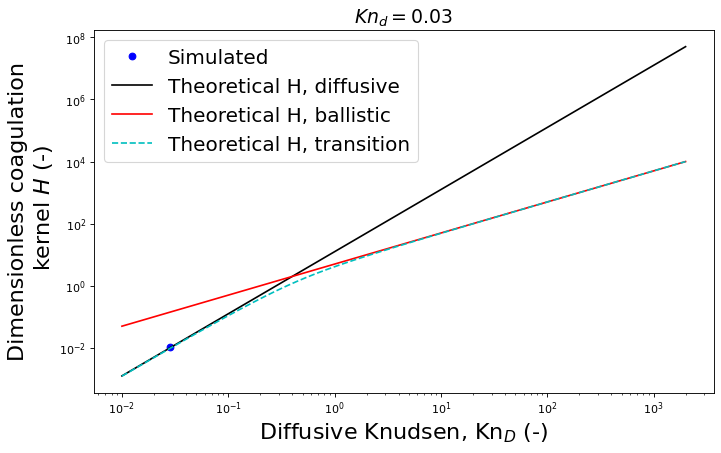

(<matplotlib.legend.Legend at 0x7fe0cd317d30>, None)

In [21]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(Kn_d_j[0],H[0],"o b",label="Simulated")
#ax1.plot(Kn_d_j[0],H_cont_teo,"x k",label="Theoretical H, diffusive")
ax1.plot(Kn_d2, H_theo_d,"-k",label="Theoretical H, diffusive")
ax1.plot(Kn_d2, H_theo_b,"-r",label="Theoretical H, ballistic")
ax1.plot(Kn_d2, H_theo,"--c",label="Theoretical H, transition")
title = "$Kn_d=$"+str(round(Kn_d_j[0],2))
plt.title(title,fontsize=17)
plt.xscale("log"); plt.yscale("log");
#plt.ylim([2e-04,8e-03]); #plt.xlim([1e-02,1e-01])
ax1.set_xlabel('Diffusive Knudsen, Kn$_D$ (-)', fontsize=20)
ax1.set_ylabel('Dimensionless coagulation\n kernel $H$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [22]:
sel_sim = simulations[simulations["A_j"] == A[0]]
sel_sim.head()

ftp_time    Kn_d_j    Kn_g_j  tau_12_j      L_j         V_box  \
0   33.821136  0.028208  0.979473  0.000004  0.00008  5.120000e-13   
1  126.253318  0.028208  0.979473  0.000004  0.00008  5.120000e-13   
2  165.836283  0.028208  0.979473  0.000004  0.00008  5.120000e-13   
3  494.057475  0.028208  0.979473  0.000004  0.00008  5.120000e-13   
4    8.119355  0.028208  0.979473  0.000004  0.00008  5.120000e-13   

           Rc_j  A_j        f_12_j        beta_j          t_ij         H  
0  9.999991e-07  0.0  1.178983e-10  2.706408e-15  4.733072e+07  0.010818  
1  9.999991e-07  0.0  1.178983e-10  2.706408e-15  4.733072e+07  0.010818  
2  9.999991e-07  0.0  1.178983e-10  2.706408e-15  4.733072e+07  0.010818  
3  9.999991e-07  0.0  1.178983e-10  2.706408e-15  4.733072e+07  0.010818  
4  9.999991e-07  0.0  1.178983e-10  2.706408e-15  4.733072e+07  0.010818

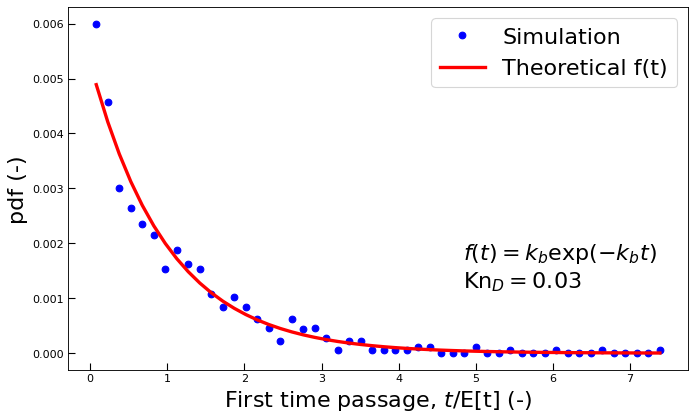

<Figure size 432x288 with 0 Axes>

In [23]:
ftp_times = sel_sim["ftp_time"].values
V_box = sel_sim["V_box"].values[0]
k = sel_sim["beta_j"].values[0]
KnD = sel_sim["Kn_d_j"].values[0]

Plot_histogram_ftp(ftp_times,V_box,k,KnD,title='pdf_ftp_diffusive',k_text="k_b")

In [24]:
sim_avg = simulations.groupby(['A_j']).mean()
sim_avg.reset_index(inplace=True)

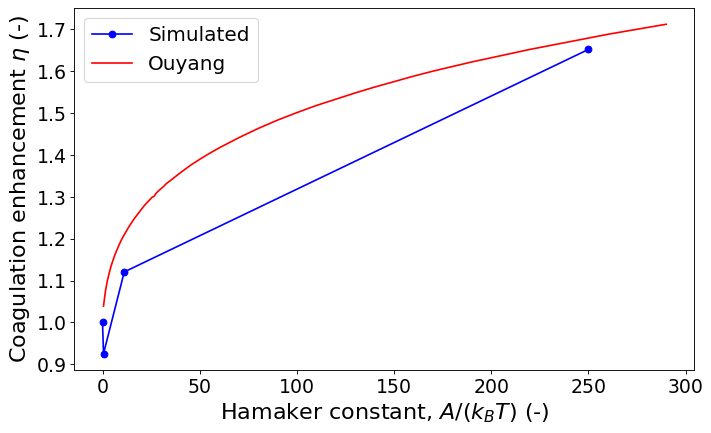

(<matplotlib.legend.Legend at 0x7fe0cc779760>, None)

In [26]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(sim_avg["A_j"]/k_BT,
         sim_avg["beta_j"]/sim_avg["beta_j"].iloc[0],"o-b",label="Simulated")
ax1.plot(ouyang_res["A/(k_b*T)"],ouyang_res["n_C"],"-r",label="Ouyang")
#plt.xscale("log")
ax1.set_xlabel('Hamaker constant, $A/(k_BT)$ (-)', fontsize=20)
ax1.set_ylabel(r'Coagulation enhancement $\eta$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

